In [2]:
from pyvirtualdisplay import Display

def play_video(frames, fps=10):
  import time
  import cv2
  from IPython.core.display import Video, display
  from moviepy.editor import VideoFileClip
  import os
  import numpy as np

  ts = time.time()
  file_name = f"{ts}.mp4"
  clip_name = f"temp-{file_name}"

  frames = np.array(frames)
  size = frames.shape[1:3][::-1]
  fourcc = cv2.VideoWriter_fourcc(*"MP4V")
  writer = cv2.VideoWriter(file_name, fourcc, fps, size)
  for frame in frames:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    writer.write(frame)
  writer.release()

  clip = VideoFileClip(file_name)
  clip.write_videofile(clip_name, logger=None)
  display(Video(clip_name, embed = True))

  os.remove(file_name)
  os.remove(clip_name)

Observation space: Discrete(64)
Action space: Discrete(4)
Current state: 0
Info: {'prob': 1}


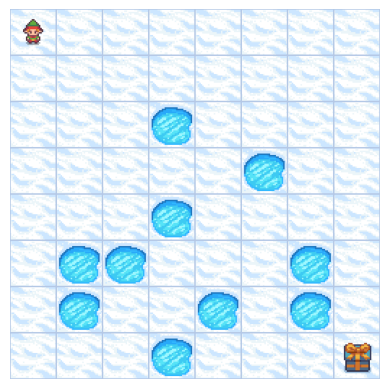

In [3]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array_list")
state, info = env.reset()

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Current state: {state}")
print(f"Info: {info}")

frames = env.render()
plt.imshow(frames[0])
plt.axis("off");

In [4]:
# reset the environment, so the agent starts at "fresh" conditions
state, info = env.reset()
print(f"Initial state: {state}\tInfo: {info}")

# performing N steps
for n in range(10):
  # decision: randomly select next action
  action = env.action_space.sample()

  # step: perform the action, get feedback from the environment
  state, reward, terminated, timeout, info = env.step(action)
  print(f"Step: {n}\tAction: {action}\tReward: {reward}\tNew state: {state}\tInfo: {info}")

  if terminated:
    print("Episode ended")
    break

# render episode frames
frames = env.render()
play_video(frames, fps=4)

Initial state: 0	Info: {'prob': 1}
Step: 0	Action: 0	Reward: 0.0	New state: 8	Info: {'prob': 0.3333333333333333}
Step: 1	Action: 2	Reward: 0.0	New state: 0	Info: {'prob': 0.3333333333333333}
Step: 2	Action: 2	Reward: 0.0	New state: 1	Info: {'prob': 0.3333333333333333}
Step: 3	Action: 1	Reward: 0.0	New state: 0	Info: {'prob': 0.3333333333333333}
Step: 4	Action: 2	Reward: 0.0	New state: 8	Info: {'prob': 0.3333333333333333}
Step: 5	Action: 1	Reward: 0.0	New state: 16	Info: {'prob': 0.3333333333333333}
Step: 6	Action: 1	Reward: 0.0	New state: 24	Info: {'prob': 0.3333333333333333}
Step: 7	Action: 2	Reward: 0.0	New state: 16	Info: {'prob': 0.3333333333333333}
Step: 8	Action: 0	Reward: 0.0	New state: 16	Info: {'prob': 0.3333333333333333}
Step: 9	Action: 3	Reward: 0.0	New state: 8	Info: {'prob': 0.3333333333333333}


C:\Users\ivane\AppData\Local\Temp\ipykernel_23584\3451692820.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Video, display


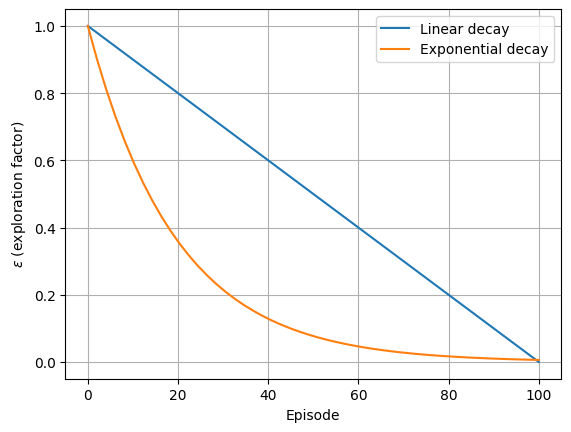

In [5]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 100)

plt.plot(t, 1-t/100, label="Linear decay")
plt.plot(t, 0.95**t, label="Exponential decay")

plt.grid()
plt.legend()
plt.xlabel("Episode")
plt.ylabel("$\epsilon$ (exploration factor)");

In [6]:
observation_space = env.observation_space.n
print("There are ", observation_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  64  possible states
There are  4  possible actions


In [7]:
def q_table(observation_space, action_space):
  Qtable = np.zeros((observation_space, action_space))
  return Qtable

q_table = q_table(observation_space, action_space)

In [8]:
import random

def make_decision(q_table, state, epsilon):
    random_float = np.random.random()

    if random_float > epsilon:
        action = np.argmax(q_table[state])
    else:
        action = np.random.choice(q_table.shape[1])

    return action

In [72]:
def train_table(q_table, current_state, action, new_state, reward, alpha, gamma):
    q_table[current_state, action] = (1 - alpha) * q_table[current_state, action] + alpha * (reward + gamma * np.max(q_table[new_state, :]))
    return q_table

In [71]:
def train(n_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table, alpha, gamma):
    total_rewards = []

    for episode in range(n_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        state, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = make_decision(q_table, state, epsilon)
            new_state, reward, done, _, _ = env.step(action)
            
            q_table = train_table(q_table, state, action, new_state, reward, alpha, gamma)

            total_reward += reward

            if done:
                break
            
            state = new_state
        
        total_rewards.append(total_reward)

    return q_table, total_rewards

In [76]:
alpha = 0.01
gamma = 0.99
n_episodes = 10000
min_epsilon = 0.1
max_epsilon = 1.0
decay_rate = 0.0005
max_steps = 200

# Train the model
q_table, total_rewards = train(n_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table, alpha, gamma)


In [77]:
episodes = 1000
nb_success = 0

# Evaluation
for _ in range(1000):
    state, _ = env.reset()
    done = False
    
    while not done:
        action = np.argmax(q_table[state])

        new_state, reward, done, info, _ = env.step(action)

        state = new_state

        nb_success += reward

print (f"Success rate = {nb_success/episodes*100}%")

Success rate = 84.8%


In [86]:
state, _ = env.reset()
done = False
step = 0

# Until the episode is done, keep taking actions
while not done:
    # Choose the action with the highest value in the current state
    action = np.argmax(q_table[state])

    # Implement this action and move the agent in the desired direction
    new_state, reward, done, info, _ = env.step(action)

    # Render the environment to visualize the episode
    env.render()

    # Update the current state
    state = new_state
    step += 1

# Close the rendering window after the episode ends
env.close()

# Output the results
if reward > 0:
    print(f"Victory! Episode finished in {step} steps.")
elif step == env.spec.max_episode_steps:
    print("Timeout! Maximum steps reached.")
else:
    print("Defeat! No victory.")

Victory! Episode finished in 67 steps.
